# Demo of MultiStageLikelihood with plain SVGP model

We demonstrate a MultiStageLikelihood driven by a multi-output SVGP model. We fit the model to samples from the
MultiStageLikelihood given toy functions from a Gaussian process draw.


In [1]:
import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from gpflow import set_trainable
from gpflow.ci_utils import ci_niter
from matplotlib import pyplot as plt

2022-07-26 12:55:45.903258: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.13/x64/lib
2022-07-26 12:55:45.903289: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import markovflow.kernels as mfk
from markovflow.models.sparse_variational import SparseVariationalGaussianProcess as SVGP
from markovflow.ssm_natgrad import SSMNaturalGradient
from markovflow.likelihoods.mutlistage_likelihood import MultiStageLikelihood

## Generate artificial data

We draw toy functions for the three likelihood parameters from a Gaussian process.

In [3]:
N = 100  # number of training points
X_train = np.arange(N).astype(float)
L = 3  # number of latent functions

2022-07-26 12:55:47.612075: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-26 12:55:47.612249: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.13/x64/lib
2022-07-26 12:55:47.612259: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-26 12:55:47.612277: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fv-az99-674): /proc/driver/nvidia/version does not exist
2022-07-26 12:55:47.612590: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FM

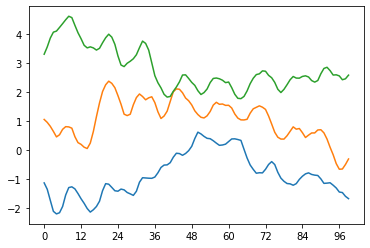

In [4]:
# Define the kernel
k1a = gpflow.kernels.Periodic(
    gpflow.kernels.Matern52(variance=1.0, lengthscales=3.0), period=12.0
)
k1b = gpflow.kernels.Matern52(variance=1.0, lengthscales=30.0)
k2 = gpflow.kernels.Matern32(variance=0.1, lengthscales=5.0)
k = k1a * k1b + k2

# Draw three independent functions from the same Gaussian process
X = X_train
num_latent = L
K = k(X[:, None])
np.random.seed(123)
v = np.random.randn(len(K), num_latent)
# We draw samples from a GP with kernel k(.) evaluated at X by reparameterizing:
# f ~ N(0, K) → f = chol(K) v, v ~ N(0, I), where chol(K) chol(K)ᵀ = K
f = np.linalg.cholesky(K + 1e-6 * np.eye(len(K))) @ v

# We shift the third function to increase the mean of the Poisson component to 20 to make it easier to identify
f += np.array([0.0, 0.0, np.log(20)]).reshape(1, L)

# Plot all three functions
plt.figure()
for i in range(num_latent):
    plt.plot(X, f[:, i])
_ = plt.xticks(np.arange(0, 100, 12))

The above latent GPs represent how the three likelihood parameters will change over time.

In [5]:
# Define the likelihood
lik = MultiStageLikelihood()
# Draw observations from the likelihood given the functions `f` from the previous step
Y = lik.sample_y(tf.convert_to_tensor(f, dtype=gpflow.default_float()))

2022-07-26 12:55:47.909726: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-07-26 12:55:47.912241: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2793435000 Hz


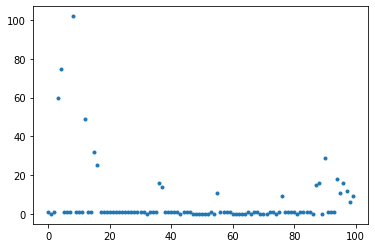

In [6]:
# Plot the observations
_ = plt.plot(X, Y, ".")

In [7]:
Y_train = Y
data = (X_train, Y_train)

## Create the model
(Note: as we are replicating the modelling task, we pretend we don't know the underlying processes that created the artificial data.)

We decide to create 3 GPs each with an independent Matern kernel, as we need three functions to drive the three parameters of the likelihood.
This will correspond to learning 6 hyperparameters (3 GPs with 2 hyper-parameters each).

In [8]:
# Create kernels
kern_list = [mfk.Matern32(variance=1.0, lengthscale=10.0, jitter=1e-6) for _ in range(L)]

In [9]:
# Create multi-output kernel from kernel list
ker = mfk.IndependentMultiOutput(kern_list)

In [10]:
# Create evenly spaced inducing points
num_inducing = N // 10
Z = np.linspace(X_train.min(), X_train.max(), num_inducing)

In [11]:
# create multi-output inducing variables from Z
inducing_variable = tf.constant(Z)

In [12]:
likelihood = MultiStageLikelihood()

In [13]:
model = SVGP(
    kernel=ker, likelihood=likelihood, inducing_points=inducing_variable, mean_function=None,
)

Instructions for updating:
Do not call `graph_parents`.


In [14]:
X_grid = X

## Optimise the model

NatGrads and Adam for SVGP

In [15]:
adam_learning_rate = 0.001
natgrad_learning_rate = 0.05

In [16]:
adam_opt = tf.optimizers.Adam(learning_rate=adam_learning_rate)
natgrad_opt = SSMNaturalGradient(gamma=natgrad_learning_rate, momentum=False)

# Stop Adam from optimizing the variational parameters

set_trainable(model.dist_q, False)
adam_var_list = model.trainable_variables
set_trainable(model.dist_q, True)

2022-07-26 12:55:48.196097: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


We separate the training process into hyper-parameters and variational parameters, which in practice, can result in better training.

For the variational parameters we can use much larger step sizes using natural gradients (whereas the hyper-parameters
take smaller steps using Adam).

This results in optimisation being more efficient (i.e. faster and better results).

In [17]:
# Variables optimized by the Adam optimizer:
print(adam_var_list)

(<tf.Variable 'lengthscale:0' shape=() dtype=float64, numpy=9.99995459903963>, <tf.Variable 'variance:0' shape=() dtype=float64, numpy=0.5413248546129181>, <tf.Variable 'lengthscale:0' shape=() dtype=float64, numpy=9.99995459903963>, <tf.Variable 'variance:0' shape=() dtype=float64, numpy=0.5413248546129181>, <tf.Variable 'lengthscale:0' shape=() dtype=float64, numpy=9.99995459903963>, <tf.Variable 'variance:0' shape=() dtype=float64, numpy=0.5413248546129181>)


In [18]:
@tf.function
def model_loss():
    return -model.elbo(data)

In [19]:
print(model_loss().numpy())

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


1532.0884355258386


In [20]:
@tf.function
def step():

    # first take step with hyper-parameters with Adam
    adam_opt.minimize(model_loss, var_list=adam_var_list)
    # then variational parameters with NatGrad
    natgrad_opt.minimize(model_loss, model.dist_q)

In [21]:
@tf.function
def sample_y(X, num_samples, correlated: bool = False):
    if correlated:
        # this path may give Cholesky errors
        f_samples = model.posterior.sample_f(X, num_samples)
    else:
        f_mean, f_var = model.posterior.predict_f(X)
        f_samples = tfp.distributions.Normal(f_mean, tf.sqrt(f_var)).sample(num_samples)
    return likelihood.sample_y(f_samples)

In [22]:
# the arguments to a tf.function-wrapped function need to be Tensors, not numpy arrays:
X_grid_tensor = tf.convert_to_tensor(X_grid)

0 tf.Tensor(68086.6646470341, shape=(), dtype=float64)
1 tf.Tensor(16146.774336100312, shape=(), dtype=float64)
2 tf.Tensor(12907.225243377443, shape=(), dtype=float64)
3 tf.Tensor(10967.86524766566, shape=(), dtype=float64)
4 tf.Tensor(9630.782966661849, shape=(), dtype=float64)
5 tf.Tensor(8632.602394179137, shape=(), dtype=float64)
6 tf.Tensor(7848.107270893277, shape=(), dtype=float64)
7 tf.Tensor(7208.921920199749, shape=(), dtype=float64)
8 tf.Tensor(6674.044442619649, shape=(), dtype=float64)
9 tf.Tensor(6217.159221030901, shape=(), dtype=float64)
10 tf.Tensor(5820.4798817918245, shape=(), dtype=float64)
11 tf.Tensor(5471.484518888985, shape=(), dtype=float64)
12 tf.Tensor(5161.061604702062, shape=(), dtype=float64)
13 tf.Tensor(4882.397677198398, shape=(), dtype=float64)
14 tf.Tensor(4630.279371111466, shape=(), dtype=float64)
15 tf.Tensor(4400.63869904649, shape=(), dtype=float64)
16 tf.Tensor(4190.247222079493, shape=(), dtype=float64)
17 tf.Tensor(3996.5046497380154, shape=(

18 tf.Tensor(3817.289193374434, shape=(), dtype=float64)
19 tf.Tensor(3650.849397750298, shape=(), dtype=float64)
20 tf.Tensor(3495.724495401596, shape=(), dtype=float64)
21 tf.Tensor(3350.6847883418595, shape=(), dtype=float64)
22 tf.Tensor(3214.6863565433982, shape=(), dtype=float64)
23 tf.Tensor(3086.836188370206, shape=(), dtype=float64)
24 tf.Tensor(2966.3650081224614, shape=(), dtype=float64)
25 tf.Tensor(2852.605867012232, shape=(), dtype=float64)
26 tf.Tensor(2744.977104220042, shape=(), dtype=float64)
27 tf.Tensor(2642.9686598718863, shape=(), dtype=float64)
28 tf.Tensor(2546.130986359373, shape=(), dtype=float64)
29 tf.Tensor(2454.06599361353, shape=(), dtype=float64)
30 tf.Tensor(2366.419600996801, shape=(), dtype=float64)
31 tf.Tensor(2282.875568973752, shape=(), dtype=float64)


32 tf.Tensor(2203.150358199736, shape=(), dtype=float64)
33 tf.Tensor(2126.9888194799983, shape=(), dtype=float64)
34 tf.Tensor(2054.1605602451646, shape=(), dtype=float64)
35 tf.Tensor(1984.456865401702, shape=(), dtype=float64)
36 tf.Tensor(1917.6880752017394, shape=(), dtype=float64)
37 tf.Tensor(1853.6813420073627, shape=(), dtype=float64)
38 tf.Tensor(1792.2787028548587, shape=(), dtype=float64)
39 tf.Tensor(1733.3354165544051, shape=(), dtype=float64)
40 tf.Tensor(1676.7185234360084, shape=(), dtype=float64)
41 tf.Tensor(1622.3055933252454, shape=(), dtype=float64)
42 tf.Tensor(1569.9836333300545, shape=(), dtype=float64)
43 tf.Tensor(1519.6481318564556, shape=(), dtype=float64)
44 tf.Tensor(1471.2022191936176, shape=(), dtype=float64)
45 tf.Tensor(1424.5559282086394, shape=(), dtype=float64)
46 tf.Tensor(1379.6255413101237, shape=(), dtype=float64)
47 tf.Tensor(1336.3330119996324, shape=(), dtype=float64)
48 tf.Tensor(1294.6054511104064, shape=(), dtype=float64)
49 tf.Tensor(125

50 tf.Tensor(1215.576768740463, shape=(), dtype=float64)
51 tf.Tensor(1178.1517774800034, shape=(), dtype=float64)
52 tf.Tensor(1142.0433218311666, shape=(), dtype=float64)
53 tf.Tensor(1107.198331609488, shape=(), dtype=float64)
54 tf.Tensor(1073.566774678851, shape=(), dtype=float64)
55 tf.Tensor(1041.101417283513, shape=(), dtype=float64)
56 tf.Tensor(1009.7576072385359, shape=(), dtype=float64)
57 tf.Tensor(979.493077419106, shape=(), dtype=float64)
58 tf.Tensor(950.2677673167282, shape=(), dtype=float64)
59 tf.Tensor(922.0436607155175, shape=(), dtype=float64)
60 tf.Tensor(894.7846377837172, shape=(), dtype=float64)
61 tf.Tensor(868.4563400878444, shape=(), dtype=float64)
62 tf.Tensor(843.0260472174784, shape=(), dtype=float64)
63 tf.Tensor(818.4625638672064, shape=(), dtype=float64)
64 tf.Tensor(794.7361163582982, shape=(), dtype=float64)
65 tf.Tensor(771.8182577014123, shape=(), dtype=float64)
66 tf.Tensor(749.6817804041012, shape=(), dtype=float64)
67 tf.Tensor(728.300636316771

68 tf.Tensor(707.6498628875454, shape=(), dtype=float64)
69 tf.Tensor(687.7055152645547, shape=(), dtype=float64)
70 tf.Tensor(668.4446037423386, shape=(), dtype=float64)
71 tf.Tensor(649.8450361002014, shape=(), dtype=float64)
72 tf.Tensor(631.8855644245416, shape=(), dtype=float64)
73 tf.Tensor(614.5457360459484, shape=(), dtype=float64)
74 tf.Tensor(597.8058482558272, shape=(), dtype=float64)
75 tf.Tensor(581.6469064964976, shape=(), dtype=float64)
76 tf.Tensor(566.0505857451031, shape=(), dtype=float64)
77 tf.Tensor(550.9991948347571, shape=(), dtype=float64)
78 tf.Tensor(536.4756434765429, shape=(), dtype=float64)
79 tf.Tensor(522.4634117645919, shape=(), dtype=float64)
80 tf.Tensor(508.9465219630002, shape=(), dtype=float64)
81 tf.Tensor(495.90951238825807, shape=(), dtype=float64)


82 tf.Tensor(483.3374132149369, shape=(), dtype=float64)
83 tf.Tensor(471.2157240448079, shape=(), dtype=float64)
84 tf.Tensor(459.5303930917324, shape=(), dtype=float64)
85 tf.Tensor(448.2677978454879, shape=(), dtype=float64)
86 tf.Tensor(437.41472708832885, shape=(), dtype=float64)
87 tf.Tensor(426.9583641476933, shape=(), dtype=float64)
88 tf.Tensor(416.8862712778915, shape=(), dtype=float64)
89 tf.Tensor(407.1863750722202, shape=(), dtype=float64)
90 tf.Tensor(397.8469528153538, shape=(), dtype=float64)
91 tf.Tensor(388.8566196934692, shape=(), dtype=float64)
92 tf.Tensor(380.20431678709474, shape=(), dtype=float64)
93 tf.Tensor(371.8792997782838, shape=(), dtype=float64)
94 tf.Tensor(363.8711283103454, shape=(), dtype=float64)
95 tf.Tensor(356.1696559441764, shape=(), dtype=float64)
96 tf.Tensor(348.76502066075517, shape=(), dtype=float64)
97 tf.Tensor(341.6476358644526, shape=(), dtype=float64)
98 tf.Tensor(334.8081818464524, shape=(), dtype=float64)
99 tf.Tensor(328.23759767174

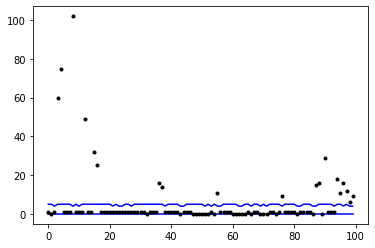

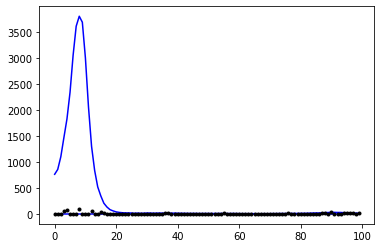

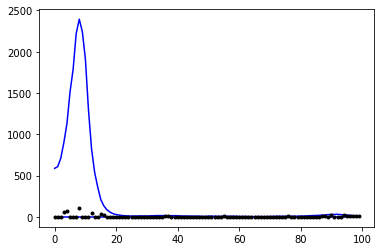

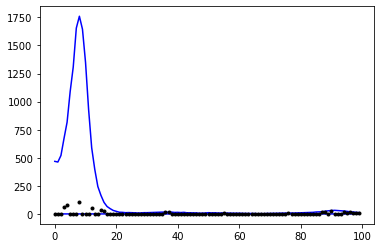

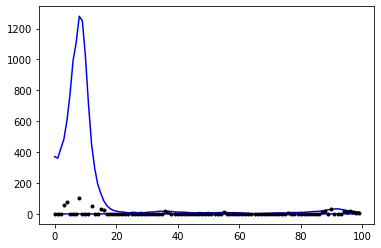

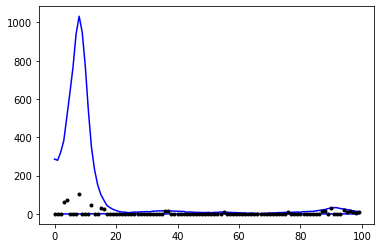

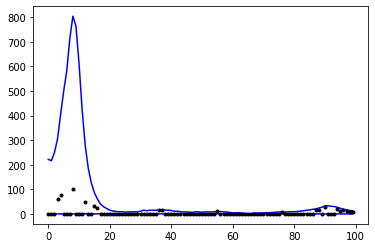

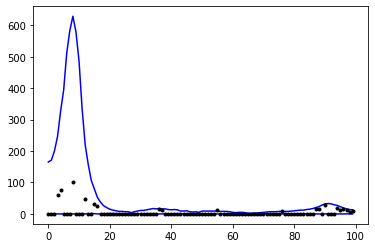

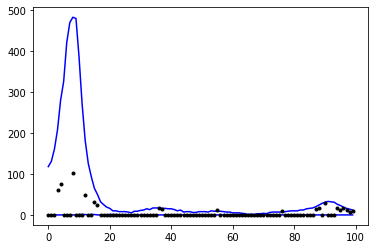

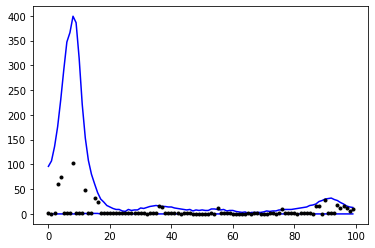

In [23]:
iterations = ci_niter(100)

# run the optimization
for it in range(iterations):
    if it % 10 == 0:

        plt.figure()
        y_samples = sample_y(X_grid_tensor, 1000)
        lower, upper = np.quantile(y_samples, q=[0.05, 0.95], axis=0).squeeze(-1)
        plt.plot(X_grid, lower, "b-")
        plt.plot(X_grid, upper, "b-")
        # f_samples = model.posterior.sample_f(X_grid, 10)
        # plt.plot(X_grid, f_samples[..., 0].numpy().T, 'b-')
        plt.plot(X_train, Y_train, "k.")
        # plt.savefig("test_%03d.png" % it)
        # plt.close()

    step()
    print(it, model_loss())

## Compare inferred functions with ground truth

In [24]:
Fmean, Fvar = model.predict_f(X_grid)

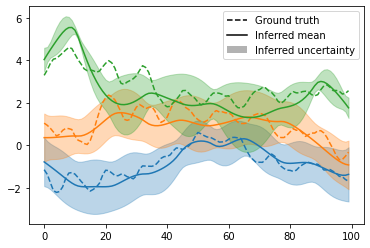

In [25]:
for i in range(num_latent):
    plt.plot(X_grid, Fmean[:, i], f"C{i}-")
    plt.fill_between(
        X_grid,
        Fmean[:, i] - 2 * tf.sqrt(Fvar[:, i]),
        Fmean[:, i] + 2 * tf.sqrt(Fvar[:, i]),
        color=f"C{i}",
        alpha=0.3,
    )

    plt.plot(X, f[:, i], f"C{i}--")

# Custom legend:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

plt.legend(
    loc="upper right",
    handles=[
        Line2D([0], [0], color="k", ls="--", label="Ground truth"),
        Line2D([0], [0], color="k", label="Inferred mean"),
        Patch(facecolor="k", alpha=0.3, label="Inferred uncertainty"),
    ],
)

The above plot shows that our linear combination of GPs with Matern kernels has done a reasonable job of representing the ground truth.